# Simulation of one voxel encoding for different probabilities


In [1]:
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
#import decimal
# import matplotlib
# matplotlib.use('Agg')    # To avoid bugs
import matplotlib.pyplot as plt
import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri


/home/sebastien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Properties of the models

Here are the properties related to the tuning curves (number, variance, ...) both true and fitted, to the neural mixture. 

In [2]:
# Define the seed to reproduce results from random processes
rand.seed(5);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored
N_array = np.array([2, 4, 6, 8, 10, 14, 20])
#N_array = np.array([6, 8, 10, 14, 16, 20])

t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 20
# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 20

# The number of sessions
n_sessions = 4

# The number of stimuli per session
n_stimuli = 380

# Way to compute the distributions from the sequence
distrib_type = 'HMM'

# Load the corresponding data
[p1g2_dist_array, p1g2_mu_array, p1g2_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli,
                                                                                      distrib_type)
# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

# Type of regression
regr = linear_model.LinearRegression(n_jobs=-1)

## Computes the response vector list

We load the design matrix, z-score it and get the response vector value.

In [ ]:
# Load the design matrices
with open("output/design_matrices/X_20sub.txt", "rb") as fp:   # Unpickling
    X = pickle.load(fp)

# Z-SCORING

# Initialization
Xz = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_fit_scheme in range(n_schemes)]

for k_fit_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
    Xz[k_fit_scheme][k_fit_N][k_subject][k_session] = np.zeros_like(X[k_fit_scheme][k_fit_N][k_subject][k_session])

# Manual Z-scoring of regressors inside the session
for k_fit_scheme, k_fit_N, k_subject in itertools.product(range(n_schemes), range(n_N), range(n_subjects)):
    n_fit_features = len(X[k_fit_scheme][k_fit_N][k_subject][0][0])
    X_mean = np.mean(np.concatenate(X[k_fit_scheme][k_fit_N][k_subject], axis=0), axis=0)
    X_sd = np.std(np.concatenate(X[k_fit_scheme][k_fit_N][k_subject], axis=0), axis=0)

    for k_session in range(n_sessions):
        for feature in range(n_fit_features):
            Xz[k_fit_scheme][k_fit_N][k_subject][k_session][:, feature]\
                = (copy.deepcopy(X[k_fit_scheme][k_fit_N][k_subject][k_session][:, feature]) - X_mean[feature] * np.ones_like(
                X[k_fit_scheme][k_fit_N][k_subject][k_session][:, feature])) / X_sd[feature]  # Centering + Standardization
    # End of z-scoring

#print(str(np.mean(np.concatenate(Xz[1][2][0],axis=0), axis=0)))

(353, 12)
Scheme : gaussian_ppc
N=6
Subject n°0
Session n°0

Tuning curve n°2 related to confidence


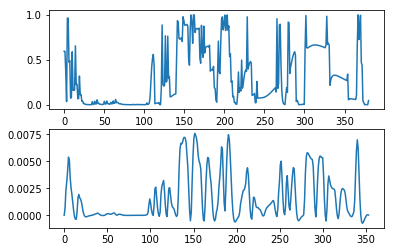

In [11]:
# Load the design matrices
with open("output/design_matrices/X_20sub.txt", "rb") as fp:   # Unpickling
    X = pickle.load(fp)

# Plot signal compared to summary statistics
k_scheme = 0
k_N = 2
k_subject = 0
k_session = 0
n_stimuli = 380

# Test everything is fine
mu = p1g2_mu_array[k_subject][k_session][0, :n_stimuli]
conf = -np.log(p1g2_sd_array[k_subject][k_session][0, :n_stimuli])
dist = p1g2_dist_array[k_subject][k_session][:, :n_stimuli]

# For gaussian PPC
N = N_array[k_N]
tc_type = 'gaussian'
t_conf = t_conf_gaussian_array[k_N]
tc_conf = tuning_curve(tc_type, N, t_conf, tc_lower_bound_conf, tc_upper_bound_conf)
#t_mu = t_mu_gaussian_array[k_N]
#tc_mu = tuning_curve(tc_type, N, t_mu, tc_lower_bound_mu, tc_upper_bound_mu)

i = 2# Tuning curve index

tc_signal =  tc_conf.f(conf, i)
print(X[k_scheme][k_N][k_subject][k_session].shape)
data_signal = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, N+i])

print('Scheme : '+scheme_array[k_scheme])
print('N='+str(N))
print('Subject n°'+str(k_subject))
print('Session n°'+str(k_session)+'\n')
print('Tuning curve n°'+str(i)+' related to confidence')

fig = plt.figure()
ax_up = fig.add_subplot(211)
ax_up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal)
ax_down = fig.add_subplot(212)
ax_down.plot(np.linspace(0, len(data_signal), len(data_signal)), data_signal)
plt.show()

#fig1 = plt.figure()
#conf = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, 1000)
#for i in range(N):
#    plt.plot(conf, tc_conf.f(conf, i))
#plt.show()

#fig2 = plt.figure()
#conf = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, 1000)
#conf = -np.log(p1g2_sd_array[k_subject][k_session][0, :n_stimuli])
#plt.plot(np.linspace(0, len(conf), len(conf)), conf)
#plt.show()

Creation of y from X, first without noise

In [ ]:
# Initialization of the response vectors and their zscore versions
y = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_true_scheme in range(n_schemes)]

yz = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_true_scheme in range(n_schemes)]

# Initialization of the weights

weights = [[[None for k_fraction in range(n_fractions)] for k_true_N in range(n_N)]
           for k_true_scheme in range(n_schemes)]


### LOOP OVER THE SCHEME
for k_true_scheme in range(n_schemes):
    true_scheme = scheme_array[k_true_scheme]

    # We replace the right value of the "t"'s according to the type of tuning curve

    if true_scheme.find('gaussian') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_gaussian_array)
        true_t_conf_array = copy.deepcopy(t_conf_gaussian_array)
        true_tc_type = 'gaussian'

    elif true_scheme.find('sigmoid') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_sigmoid_array)
        true_t_conf_array = copy.deepcopy(t_conf_sigmoid_array)
        true_tc_type = 'sigmoid'

    # We consider combinations of population fractions for PPC and rate codes
    if true_scheme.find('ppc') != -1 or true_scheme.find('rate') != -1:
        # The number of population fraction tested (related to W)
        population_fraction_array = copy.deepcopy(np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]]))
    elif true_scheme.find('dpc') != -1:  # DPC case
        population_fraction_array = copy.deepcopy(np.array([[1]]))
    n_population_fractions = len(population_fraction_array)

    ### LOOP OVER N_true
    for k_true_N in range(n_N):
        true_N = N_array[k_true_N]
        # Creation of the true tuning curve objects
        true_t_mu = true_t_mu_array[k_true_N]
        true_t_conf = true_t_conf_array[k_true_N]
        true_tc_mu = tuning_curve(true_tc_type, true_N, true_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
        true_tc_conf = tuning_curve(true_tc_type, true_N, true_t_conf, tc_lower_bound_conf,
                                     tc_upper_bound_conf)

        if true_scheme.find('ppc') != -1:
            true_tc = [true_tc_mu, true_tc_conf]
        elif true_scheme.find('dpc') != -1:
            true_tc = [true_tc_mu]
        elif true_scheme.find('rate') != -1:
            true_tc = []

        ### LOOP OVER THE W's
        # The number of subpopulation fractions acc. to the scheme
        n_subpopulation_fractions = int(n_fractions / n_population_fractions)
        fraction_counter = 0
        for k_population_fraction, population_fraction in enumerate(population_fraction_array):
            # The number of populations acc. to the scheme (2 for PPC and rate, 1 for DPC)
            n_population = len(population_fraction)
            for k_subpopulation_fraction in range(n_subpopulation_fractions):
                if true_scheme.find('ppc') != -1 or true_scheme.find('dpc') != -1:
                    # We consider one sparsity per remainder value of the counter divided by the number
                    # of combinations to be tested
                    subpopulation_sparsity_exp = sparsity_exp_array[fraction_counter % n_sparsity_exp]
                    # Fraction of each neural subpopulation
                    subpopulation_fraction = neural_proba.get_subpopulation_fraction(n_population, true_N,
                                                                                     subpopulation_sparsity_exp)
                else:  # Rate case
                    population_fraction = np.array([1, 1])

                # Generate the data from the voxel
                true_voxel = voxel(true_scheme, population_fraction, subpopulation_fraction,
                                   [true_tc_mu, true_tc_conf])
                n_true_features = n_population * true_N
                weights_tmp = np.reshape(true_voxel.weights, (n_true_features,))
                # Allocation of the weight tensor
                weights[k_true_scheme][k_true_N][fraction_counter] \
                    = copy.deepcopy(weights_tmp)


                ### LOOP OVER THE SUBJECTS
                for k_subject in range(n_subjects):

                    ### LOOP OVER THE SESSIONS : simulating the response
                    for k_session in range(n_sessions):
                            # We use X to compute y order to save some computation time
                            # Temporary variables to lighten the reading
                            X_tmp = copy.deepcopy(X[k_true_scheme][k_true_N][k_subject][k_session])
                            y_tmp = copy.deepcopy(np.dot(X_tmp, weights_tmp))

                            # Allocation of the tensor
                            y[k_true_scheme][k_true_N][fraction_counter][k_subject][
                                k_session] = copy.deepcopy(y_tmp)


                fraction_counter += 1

                 

In [ ]:
# Noise injection

#print('Without added noise :'+str(y[0][1][1][2][2]))

# Compute the amplitude of the noise (std of the added gaussian noise)
for k_fit_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    all_y = np.asarray(y[k_fit_scheme][k_true_N]).flatten()    # Concatenation of all y grouped together for SNR computation
    print(np.sqrt(np.var(all_y)*(1/snr-1)))
    noise_sd = np.sqrt(np.var(all_y)*(1/snr-1))
    del all_y    # Free memory
    for fraction_counter, k_subject, k_session in itertools.product(range(n_fractions), range(n_subjects), range(n_sessions)):
        y[k_true_scheme][k_true_N][fraction_counter][k_subject][k_session] = copy.deepcopy(y[k_true_scheme][k_true_N][fraction_counter][k_subject][k_session] 
            + np.random.normal(0, noise_sd, len(y[k_true_scheme][k_true_N][fraction_counter][k_subject][k_session])))
        print(np.random.normal(0, noise_sd, len(y[k_true_scheme][k_true_N][fraction_counter][k_subject][k_session])))

# PB : MEME Y AVANT ET APRES LE BRUIT ! ! ! ! 
#print('With added noise :'+str(y[0][1][1][2][2]))

for k_fit_scheme, k_true_N, fraction_counter, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):

    # Z-scoring of y
    y_mean = np.mean(np.concatenate(np.asarray(y[k_true_scheme][fraction_counter][k_true_N][k_subject]),
                                    axis=0))
    y_sd = np.std(np.concatenate(np.asarray(y[k_true_scheme][fraction_counter][k_true_N][k_subject]),
                                 axis=0))

    for k_session in range(n_sessions):
        yz[k_true_scheme][fraction_counter][k_true_N][k_subject][k_session] = \
            (copy.deepcopy(y[k_true_scheme][fraction_counter][k_true_N][k_subject][k_session]) - y_mean) / y_sd    # Centering and standardization

    ### End of z-scoring of y


## Example of training and test set : illustration, example

Here we select arbitrary values of hyperparameters and plot the result for one fit.


In [ ]:
k_scheme = 0
k_true_N = 1
k_fraction = 10
k_subject = 0

print('Scheme :'+scheme_array[k_scheme]+'\n'+'true_N ='+str(N_array[k_true_N])+'\n'+'Subject number '+str(k_subject))

# width = np.mean(mu)/(2*ppc_voxel.tuning_curve[0].N)
#
# fig = plt.figure()
# ax = fig.add_subplot(111)
# x = np.linspace(0, 1, ppc_voxel.tuning_curve[0].N)
# ax.bar(x, ppc_voxel.subpopulation_fraction[0], width=width)
# utils.plot_detail(fig, ax, 'p(Head)', 'Neural fraction', xtick_fontsize, xfontstyle='italic')
# ax.tick_params(labelsize=xtick_fontsize)
# ax.set_title('Mixture in this voxel', fontsize=20)
# plt.savefig('output/figures/mixture_mu.png', bbox_inches='tight')
#
# plt.show()


#
# width = np.mean(mu)/(2*ppc_voxel.tuning_curve[1].N)*(tc_upper_bound_conf-tc_lower_bound_conf)
#
# fig = plt.figure()
# ax = fig.add_subplot(111)
# x = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, ppc_voxel.tuning_curve[1].N)
# ax.bar(x, ppc_voxel.subpopulation_fraction[1], width=width)
# utils.plot_detail(fig, ax, 'Uncertainty (s.d.)', 'Neural fraction', xtick_fontsize)
# ax.set_title('Mixture in this voxel', fontsize=20)
# plt.savefig('output/figures/mixture_conf.png', bbox_inches='tight')
#
# plt.show()


In [ ]:
# The quantity to be computed during the cross validation
r2_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
r2_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))


In [ ]:
a = [[[1, 100], [10,2], [40, 3]], [[10, 1], [1,21], [1, 32]], [[90, 1], [0.1,2], [0, 3]], [[1, 1], [1,2], [1, 3]]]
b = np.concatenate(np.concatenate(a, axis=0), axis=0)
c = np.asarray(a).flatten()
print(np.sqrt(2))